In [1]:
#IMPORT ALL NECESSARY PACKAGES AT THE TOP OF THE CODE
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

# Custom display helpers
from IPython.display import Markdown

def md_print(md_str: str):
    display(Markdown(md_str))

def lax_eq(equation):
    return sym.latex(equation , mode='inline')


In [2]:
import sympy as sym

def integrate(f, xt, dt):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.

    Parameters
    ============
    dyn: Python function
        derivate of the system at a given step x(t),
        it can considered as \dot{x}(t) = func(x(t))
    xt: NumPy array
        current step x(t)
    dt:
        step size for integration

    Return
    ============
    new_xt:
        value of x(t+dt) integrated from x(t)
    """
    k1 = dt * f(xt)
    k2 = dt * f(xt+k1/2.)
    k3 = dt * f(xt+k2/2.)
    k4 = dt * f(xt+k3)
    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

def simulate(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).

    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t),
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,dt)
        x = np.copy(xtraj[:,i])
    return tvec , xtraj


def get_eu_la(L: sym.Function, q: sym.Matrix, t: sym.symbols):
    """Generate euler lagrangian using sympy jacobian

    Args:
        L (sym.Function): Lagrangian equation
        q (sym.Matrix): matrix of system-var q
        t (sym.symbols): time symbol (needed for q.diff(t))
    """

    q_dot = q.diff(t)
    dL_dq = sym.simplify(sym.Matrix([L]).jacobian(q).T)
    dL_dq_dot = sym.simplify(sym.Matrix([L]).jacobian(q_dot).T)

    return sym.simplify(dL_dq_dot.diff(t) - dL_dq)


def solve_and_print(variables: sym.Matrix,
                    eu_la_eq: sym.Eq , quiet = False) -> list[dict[any]]:
    """Solve the given eu_la equation  

    Args:
        variables (sym.Matrix): var to solve for
        eu_la_eq (sym.Eq): eu_la equation
        quiet (bool): turn off any printing if True

    Returns:
        list[dict[sym.Function]]: list of solution dicts (keyed with variables)
    """
    solution_dicts = sym.solve(eu_la_eq, variables, dict=True)
    i = 0
    for solution_dict in solution_dicts:
        i += 1
        if not quiet: md_print(f"solution : {i} / {len(solution_dicts)}") 
        for var in variables:
            sol = solution_dict[var]
            if not quiet: md_print(f"{lax_eq(var)} = {lax_eq(sym.simplify(sol))}")
    return solution_dicts

def lambdify_sys(var_list: list, function_dict: dict[any, sym.Function], keys =None):
    lambda_dict ={}
    if keys is None:
        keys = function_dict.keys()
    for var in keys:
        acceleration_function = (function_dict[var])
        lambda_func = sym.lambdify(var_list, acceleration_function )
        lambda_dict[var] = lambda_func
    return lambda_dict


def make_system_equation(lambda_dict,lam_keys):
    def system_equation(state , lambda_dict ,lam_keys):
        '''
        argumetn:
        state -> array of 4 item, x,theta,xdot ,thetadot
        return -> array of 4 item, xdot, thetadot, xddot, thetaddot
        '''
        q_1 = state[0]
        q_2 =state[1]
        v_1 = state[2]
        v_2 = state[3]
        a_1 =  lambda_dict[lam_keys[0]](q_1,q_2,v_1,v_2)
        a_2 = lambda_dict[lam_keys[1]](q_1,q_2,v_1,v_2)

        return np.array([v_1,v_2,a_1 ,a_2])
    
    return lambda state: system_equation(state , lambda_dict , lam_keys)



## Problem 1 solution


In [3]:
# P1
def problem1():

    t= sym.symbols('t')
    tau= sym.symbols('\tau')
    R , m   = sym.symbols(r'R,m') # spring constants
    theta = sym.Function(r'\theta')(t)
    psi = sym.Function(r'\psi')(t)
    g = sym.symbols('g')
    # g = -9.8

    theta_dot = theta.diff(t)
    psi_dot = psi.diff(t)

    # Energies
    v1 = R*sym.sin(theta) * psi_dot
    v2 = R*theta_dot
    KE = 0.5 * m * (v1)**2 + 0.5 * m * (v2)**2
    PE = -m * R * sym.cos(theta) * g


    L = sym.simplify(KE - PE)

    q = sym.Matrix([theta,psi])
    q_ddot = q.diff(t).diff(t)

    eu_la = get_eu_la(L,q,t)
    md_print(f"eu_la : {lax_eq(eu_la)}")

    force = sym.Matrix([0,tau])

    eu_la_eq = sym.Eq(eu_la , force)

    md_print("**Solutions for q_ddot with forced eu la system**")
    solved_eq = solve_and_print(q_ddot, eu_la_eq)[0]

problem1()


eu_la : $\left[\begin{smallmatrix}R m \left(1.0 R \frac{d^{2}}{d t^{2}} \theta{\left(t \right)} - \left(1.0 R \cos{\left(\theta{\left(t \right)} \right)} \left(\frac{d}{d t} \psi{\left(t \right)}\right)^{2} - g\right) \sin{\left(\theta{\left(t \right)} \right)}\right)\\R^{2} m \left(1.0 \sin{\left(2 \theta{\left(t \right)} \right)} \frac{d}{d t} \psi{\left(t \right)} \frac{d}{d t} \theta{\left(t \right)} - 0.5 \cos{\left(2 \theta{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \psi{\left(t \right)} + 0.5 \frac{d^{2}}{d t^{2}} \psi{\left(t \right)}\right)\end{smallmatrix}\right]$

**Solutions for q_ddot with forced eu la system**

solution : 1 / 1

$\frac{d^{2}}{d t^{2}} \theta{\left(t \right)}$ = $\left(R \cos{\left(\theta{\left(t \right)} \right)} \left(\frac{d}{d t} \psi{\left(t \right)}\right)^{2} - g\right) \sin{\left(\theta{\left(t \right)} \right)} / R$

$\frac{d^{2}}{d t^{2}} \psi{\left(t \right)}$ = $\frac{2.0 \left(R^{2} m \sin{\left(2.0 \theta{\left(t \right)} \right)} \frac{d}{d t} \psi{\left(t \right)} \frac{d}{d t} \theta{\left(t \right)} - au\right)}{R^{2} m \left(\cos{\left(2.0 \theta{\left(t \right)} \right)} - 1\right)}$

## Problem 2 Solution

In [4]:
# p2

def Problem2():

    from sympy import cos, sin
    t= sym.symbols('t')
    m,g,k = sym.symbols(r"m,g,k")
    theta,psi,phi = sym.symbols(r"\theta,\psi,\phi")

    x = sym.Function('x')(t)
    y = sym.Function('y')(t)
    z = sym.Function('z')(t)
    xdot = x.diff(t)
    ydot = y.diff(t)
    zdot = z.diff(t)

    q = sym.Matrix([x,y,z])

    def get_L(xyz):
        x = xyz[0]
        y = xyz[1]
        z = xyz[2]
        return 0.5 * m * (x.diff(t)**2 + y.diff(t)**2 + z.diff(t)**2) - 0.5 * k * (
        x**2 + y**2 + z**2) - m * g * z


    # original_L = 0.5 * m * (xdot**2 + ydot**2 + zdot**2) - 0.5 * k * (
    #     x**2 + y**2 + z**2) - m * g * z
    old_L = get_L(q)

    rot_theta = sym.Matrix([
        [cos(theta), -sin(theta), 0],
        [sin(theta), cos(theta), 0],
        [0, 0, 1],
    ])
    rot_psi = sym.Matrix([
        [cos(psi), 0, sin(psi)],
        [0, 1, 0],
        [-sin(psi),0, cos(psi)]
    ])
    rot_phi = sym.Matrix([
        [1,0, 0],
        [0,cos(phi), -sin(phi)],
        [0,sin(phi), cos(phi)],
    ])


    # inner function, capturing lots of outside stuff
    def part1(Rot):
        q_new = Rot @ q
        md_print(f"For {lax_eq(Rot)} New q: {lax_eq(q_new)}")

        new_L= get_L(q_new)

        md_print(f"**global invariance (old == new) ? {old_L == new_L.simplify()}**")
        md_print(f"**local invariance (old.diff(t) == new.diff(t))? {old_L.diff(t).simplify() == new_L.simplify().diff(t).simplify()}**")
    md_print("**Problem2, part 1 solutions:**")
    part1(rot_theta)
    part1(rot_psi)
    part1(rot_phi)


    # Part 2, small angle 

    rot_theta_small_a = sym.Matrix([
        [1, -theta, 0],
        [theta, 1, 0],
        [0, 0, 1],
    ])
    rot_psi_small_a = sym.Matrix([
        [1, 0, psi],
        [0, 1, 0],
        [-psi,0, 1]
    ])
    rot_phi_small_a = sym.Matrix([
        [1,0, 0],
        [0,1, -phi],
        [0,phi, 1],
    ])
    
    def part2(rot_s_a):
        q_eps = rot_s_a @ q
        md_print(f"For {lax_eq(rot_s_a)} New $q_\epsilon$: {lax_eq(q_eps)}")

        L_error = get_L(q_eps).simplify() - old_L.simplify()
        md_print(f"Difference in L: {lax_eq(L_error.simplify())}")

    md_print("**Problem2, part 2 solutions:**")
    part2(rot_theta_small_a)
    part2(rot_psi_small_a)
    part2(rot_phi_small_a)

    # part 3 
    display(q)
    old_dL_dq = sym.simplify(sym.Matrix([old_L]).jacobian(q).T)
    display(old_dL_dq)
    md_print("**Nothing from dL/dq is zero. Must change the coordinate**")

    # Change xy into polar
    
    theta = sym.Function(r'\theta')(t)
    r = sym.Function('r')(t)
    q_polar = sym.Matrix([
        theta,
        r,
        z
    ])
    md_print(f"Changed to a new coordinate of {lax_eq(q_polar)}")
    xyz_polar = sym.Matrix(
        [
        r* cos(theta),
        r* sin(theta),
        z])
    
    L_polar = get_L(xyz_polar)
    dL_dq_polar = sym.simplify(sym.Matrix([L_polar]).jacobian(q_polar).T)
    display(dL_dq_polar)
    md_print("**Obviously in the new coordinate: theta term result in 0, theta is a conserved quantity**")

    dL_dqdot_polar = sym.simplify(sym.Matrix([L_polar]).jacobian(q_polar.diff(t)).T)
    md_print(f"dL/dqdot {lax_eq(dL_dqdot_polar)}")
    md_print(f"**The conserved quantity is {lax_eq (dL_dqdot_polar[0])}, means rotational moment**")


Problem2()

**Problem2, part 1 solutions:**

For $\left[\begin{smallmatrix}\cos{\left(\theta \right)} & - \sin{\left(\theta \right)} & 0\\\sin{\left(\theta \right)} & \cos{\left(\theta \right)} & 0\\0 & 0 & 1\end{smallmatrix}\right]$ New q: $\left[\begin{smallmatrix}x{\left(t \right)} \cos{\left(\theta \right)} - y{\left(t \right)} \sin{\left(\theta \right)}\\x{\left(t \right)} \sin{\left(\theta \right)} + y{\left(t \right)} \cos{\left(\theta \right)}\\z{\left(t \right)}\end{smallmatrix}\right]$

**global invariance (old == new) ? True**

**local invariance (old.diff(t) == new.diff(t))? True**

For $\left[\begin{smallmatrix}\cos{\left(\psi \right)} & 0 & \sin{\left(\psi \right)}\\0 & 1 & 0\\- \sin{\left(\psi \right)} & 0 & \cos{\left(\psi \right)}\end{smallmatrix}\right]$ New q: $\left[\begin{smallmatrix}x{\left(t \right)} \cos{\left(\psi \right)} + z{\left(t \right)} \sin{\left(\psi \right)}\\y{\left(t \right)}\\- x{\left(t \right)} \sin{\left(\psi \right)} + z{\left(t \right)} \cos{\left(\psi \right)}\end{smallmatrix}\right]$

**global invariance (old == new) ? False**

**local invariance (old.diff(t) == new.diff(t))? False**

For $\left[\begin{smallmatrix}1 & 0 & 0\\0 & \cos{\left(\phi \right)} & - \sin{\left(\phi \right)}\\0 & \sin{\left(\phi \right)} & \cos{\left(\phi \right)}\end{smallmatrix}\right]$ New q: $\left[\begin{smallmatrix}x{\left(t \right)}\\y{\left(t \right)} \cos{\left(\phi \right)} - z{\left(t \right)} \sin{\left(\phi \right)}\\y{\left(t \right)} \sin{\left(\phi \right)} + z{\left(t \right)} \cos{\left(\phi \right)}\end{smallmatrix}\right]$

**global invariance (old == new) ? False**

**local invariance (old.diff(t) == new.diff(t))? False**

**Problem2, part 2 solutions:**

For $\left[\begin{smallmatrix}1 & - \theta & 0\\\theta & 1 & 0\\0 & 0 & 1\end{smallmatrix}\right]$ New $q_\epsilon$: $\left[\begin{smallmatrix}- \theta y{\left(t \right)} + x{\left(t \right)}\\\theta x{\left(t \right)} + y{\left(t \right)}\\z{\left(t \right)}\end{smallmatrix}\right]$

Difference in L: $0.5 \theta^{2} \left(- k x^{2}{\left(t \right)} - k y^{2}{\left(t \right)} + m \left(\frac{d}{d t} x{\left(t \right)}\right)^{2} + m \left(\frac{d}{d t} y{\left(t \right)}\right)^{2}\right)$

For $\left[\begin{smallmatrix}1 & 0 & \psi\\0 & 1 & 0\\- \psi & 0 & 1\end{smallmatrix}\right]$ New $q_\epsilon$: $\left[\begin{smallmatrix}\psi z{\left(t \right)} + x{\left(t \right)}\\y{\left(t \right)}\\- \psi x{\left(t \right)} + z{\left(t \right)}\end{smallmatrix}\right]$

Difference in L: $\psi \left(- 0.5 \psi k x^{2}{\left(t \right)} - 0.5 \psi k z^{2}{\left(t \right)} + 0.5 \psi m \left(\frac{d}{d t} x{\left(t \right)}\right)^{2} + 0.5 \psi m \left(\frac{d}{d t} z{\left(t \right)}\right)^{2} + 1.0 g m x{\left(t \right)}\right)$

For $\left[\begin{smallmatrix}1 & 0 & 0\\0 & 1 & - \phi\\0 & \phi & 1\end{smallmatrix}\right]$ New $q_\epsilon$: $\left[\begin{smallmatrix}x{\left(t \right)}\\- \phi z{\left(t \right)} + y{\left(t \right)}\\\phi y{\left(t \right)} + z{\left(t \right)}\end{smallmatrix}\right]$

Difference in L: $\phi \left(- 0.5 \phi k y^{2}{\left(t \right)} - 0.5 \phi k z^{2}{\left(t \right)} + 0.5 \phi m \left(\frac{d}{d t} y{\left(t \right)}\right)^{2} + 0.5 \phi m \left(\frac{d}{d t} z{\left(t \right)}\right)^{2} - 1.0 g m y{\left(t \right)}\right)$

Matrix([
[x(t)],
[y(t)],
[z(t)]])

Matrix([
[      -1.0*k*x(t)],
[      -1.0*k*y(t)],
[-g*m - 1.0*k*z(t)]])

**Nothing from dL/dq is zero. Must change the coordinate**

Changed to a new coordinate of $\left[\begin{smallmatrix}\theta{\left(t \right)}\\r{\left(t \right)}\\z{\left(t \right)}\end{smallmatrix}\right]$

Matrix([
[                                            0],
[1.0*(-k + m*Derivative(\theta(t), t)**2)*r(t)],
[                            -g*m - 1.0*k*z(t)]])

**Obviously in the new coordinate: theta term result in 0, theta is a conserved quantity**

dL/dqdot $\left[\begin{smallmatrix}1.0 m r^{2}{\left(t \right)} \frac{d}{d t} \theta{\left(t \right)}\\1.0 m \frac{d}{d t} r{\left(t \right)}\\1.0 m \frac{d}{d t} z{\left(t \right)}\end{smallmatrix}\right]$

**The conserved quantity is $1.0 m r^{2}{\left(t \right)} \frac{d}{d t} \theta{\left(t \right)}$, means rotational moment**

## Problem 3 solution

Sovled dL/dq $\left[\begin{smallmatrix}0\\1.0 R m \left(g - \frac{d}{d t} \theta{\left(t \right)} \frac{d}{d t} x{\left(t \right)}\right) \sin{\left(\theta{\left(t \right)} \right)}\end{smallmatrix}\right]$

Found a conserved quantities with $x{\left(t \right)}$

Conserved term is $1.0 M \frac{d}{d t} x{\left(t \right)} + 1.0 R m \cos{\left(\theta{\left(t \right)} \right)} \frac{d}{d t} \theta{\left(t \right)} + 1.0 m \frac{d}{d t} x{\left(t \right)}$

solution : 1 / 1

$\frac{d^{2}}{d t^{2}} x{\left(t \right)}$ = $\frac{\left(49.0 \cos{\left(\theta{\left(t \right)} \right)} - 5.0 \left(\frac{d}{d t} \theta{\left(t \right)}\right)^{2}\right) \sin{\left(\theta{\left(t \right)} \right)}}{5.0 \cos^{2}{\left(\theta{\left(t \right)} \right)} - 15.0}$

$\frac{d^{2}}{d t^{2}} \theta{\left(t \right)}$ = $\frac{\left(5.0 \cos{\left(\theta{\left(t \right)} \right)} \left(\frac{d}{d t} \theta{\left(t \right)}\right)^{2} - 147.0\right) \sin{\left(\theta{\left(t \right)} \right)}}{5.0 \cos^{2}{\left(\theta{\left(t \right)} \right)} - 15.0}$

**Momentum for the var $x{\left(t \right)}$**

[]

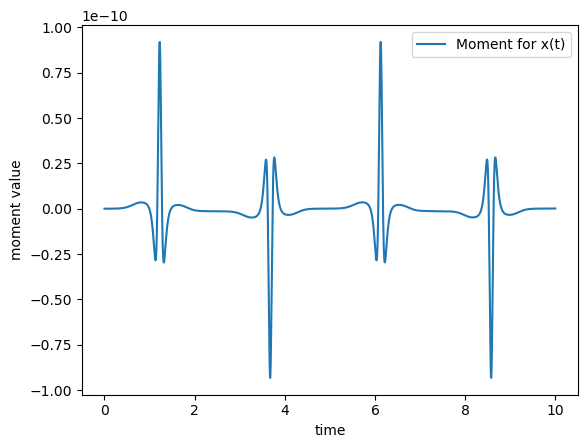

In [17]:
# P3 

t = sym.symbols('t')
R, m_pen, M_cart , gravity = sym.symbols('R,m,M,g')
x = sym.Function(r'x')(t)
x_dot = x.diff(t)

theta = sym.Function(r'\theta')(t)
theta_dot = theta.diff(t)


q = sym.Matrix([x,theta])
q_ddot = q.diff(t).diff(t)
PE = gravity * m_pen * R * sym.cos(theta)

# Velocity in x
# X velocity of the ball is on top of cart's velocity
pen_x_vel = R * theta_dot * sym.cos(theta) + x_dot
pen_y_vel = R * theta_dot * sym.sin(theta)

KE = 0.5 * M_cart * x_dot**2 + 0.5 * m_pen * pen_x_vel**2 + 0.5 * m_pen * pen_y_vel**2
lagrangian = sym.simplify(KE - PE)

subs_list = [(M_cart,2) , (m_pen,1) , (R , 1) , (gravity,9.8)]
# Find the conserved quantities

dL_dq = sym.simplify(sym.Matrix([lagrangian]).jacobian(q).T)
dL_dqdot = sym.simplify(sym.Matrix([lagrangian]).jacobian(q.diff(t)).T)
md_print(f"Sovled dL/dq {lax_eq(dL_dq)}")

p_dict = {}
p_dict_lam = {}
for i in range(len(q)):
    if dL_dq[i] == 0:
        md_print(f"Found a conserved quantities with {lax_eq(q[i])}")
        md_print(f"Conserved term is {lax_eq(dL_dqdot[i])}")
        p_dict[q[i]] = dL_dqdot[i]
        p_dict_lam [q[i]] = sym.lambdify([x,theta,x_dot,theta_dot],dL_dqdot[i].subs(subs_list))

# This problem and next share the same eu_la and constants 
eu_la = get_eu_la(lagrangian.subs(subs_list) , q,t)

# md_print("Solved eu_la:")
eu_la_solved = solve_and_print(q_ddot,sym.Eq(eu_la, sym.Matrix([0,0])) , False)[0]

# p7_lambda_dict = {}

# for q in q_ddot:
#     eq_subed = sol[q].subs(p7_subs_list)
#     md_print( f"subsitued with constants: {lax_eq(sym.simplify (sym.Eq(q,eq_subed)))}")
#     p7_lambda_dict[q] = sym.lambdify( [x,theta,x_dot,theta_dot] ,eq_subed)

lambda_dict = lambdify_sys([x,theta,x_dot,theta_dot] , eu_la_solved , q_ddot)

# def system_equation(state):
#     '''
#     argumetn:
#     state -> array of 4 item, x,theta,xdot ,thetadot
#     return -> array of 4 item, xdot, thetadot, xddot, thetaddot
#     '''
#     x_pos = state[0]
#     theta_pos =state[1]
#     x_v = state[2]
#     theta_v = state[3]
#     x_a =  lambda_dict[q_ddot[0]](x_pos,theta_pos,x_v,theta_v)
#     theta_a = lambda_dict[q_ddot[1]](x_pos,theta_pos,x_v,theta_v)

#     return np.array([x_v,theta_v,x_a ,theta_a])

system_equation = make_system_equation(lambda_dict , q_ddot)

# initial state, same as q7
s0 = np.array([0,0.1 , 0 , 0])
t_range = [0,10]
p3_tvec,p3_traj = simulate(system_equation , s0 , t_range , 0.001 , integrate)

# for state in p3_traj.T:
#     print(state)

plt.figure(1)

for key in p_dict_lam.keys():
    md_print(f"**Momentum for the var {lax_eq(key)}**")

    moments = []
    for state in p3_traj.T:
        moments.append(p_dict_lam[key](state[0],state[1],state[2],state[3]))
    plt.plot(p3_tvec, moments , label = f"Moment for {key}" )

plt.xlabel("time")
plt.ylabel("moment value")
plt.legend()
plt.plot()


In [6]:
def animate_cart_pend(traj_array,R=1,T=15):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
    ================================================
    traj_array:
        trajectory of theta and x, should be a NumPy array with
        shape of (2,N)
    R:
        length of the pendulum
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data from pendulum angle trajectories.
    xcart=traj_array[0]
    ycart = 0.0*np.ones(traj_array[0].shape)
    N = len(traj_array[1])

    xx1=xcart+R*np.sin(traj_array[1])
    yy1=R*np.cos(traj_array[1])

     # Need this for specifying length of simulation

    ####################################
    # Using these to specify axis limits.
    xm=-4
    xM= 4
    ym=-4
    yM= 4

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[
          dict(x=xcart, y=ycart, 
               mode='markers', name='Cart Traj', 
               marker=dict(color="green", size=2)
              ),
          dict(x=xx1, y=yy1, 
               mode='lines', name='Arm', 
               line=dict(width=2, color='blue')
              ),
           dict(x=xx1, y=yy1, 
               mode='lines', name='Pendulum',
               line=dict(width=2, color='purple')
              ),

           dict(x=xx1, y=yy1, 
               mode='markers', name='Pendulum Traj', 
               marker=dict(color="purple", size=2)
              ),
        ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Cart Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[go.Scatter(
                            x=[xcart[k]],
                            y=[ycart[k]],
                            mode="markers",
                            marker_symbol="square",
                            marker=dict(color="blue", size=30)),
                       
                       dict(x=[xx1[k],xcart[k]], 
                            y=[yy1[k],ycart[k]], 
                            mode='lines',
                            line=dict(color='red', width=3)
                            ),
                       go.Scatter(
                            x=[xx1[k]],
                            y=[yy1[k]],
                            mode="markers",
                            marker=dict(color="blue", size=12)),

                      ]) for k in range(N)]

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

## Problem 4 solution

[]

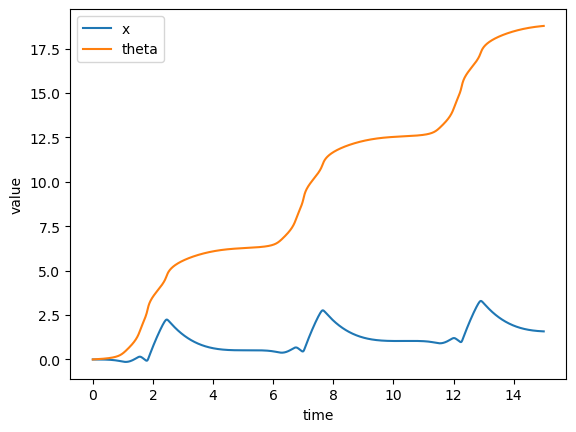

In [20]:
# P4

# Constrain x+y^2-1=0
lambda_scaler = sym.symbols('\lambda')
constrain_phi = -(x+R*sym.sin(theta)) - (R*sym.cos(theta))**2 +1
constrain_phi = constrain_phi.subs(subs_list)
phi_dt1 = sym.simplify(constrain_phi.diff(x))
phi_dt2 = sym.simplify(constrain_phi.diff(theta))

constrain_ddt = sym.simplify(constrain_phi.diff(t).diff(t))

constrained_system_eq = sym.Eq(
    sym.Matrix(
        [eu_la[0] - lambda_scaler * phi_dt1,
         eu_la[1] - lambda_scaler * phi_dt2,
         constrain_ddt]),
    sym.Matrix([0, 0, 0]))


p4_vars = [x_dot.diff(t) , theta_dot.diff(t) , lambda_scaler]

eu_la_solved = solve_and_print(p4_vars,constrained_system_eq ,True)[0]
lambda_dict_p4 = lambdify_sys([x,theta,x_dot,theta_dot] , eu_la_solved,p4_vars)

# system_equation_p4 = make_system_equation(lambda_dict_p4 , q_ddot)

def system_equation_p4(state):
    '''
    argumetn:
    state -> array of 4 item, x,theta,xdot ,thetadot
    return -> array of 4 item, xdot, thetadot, xddot, thetaddot
    '''
    x_pos = state[0]
    theta_pos =state[1]
    x_v = state[2]
    theta_v = state[3]
    x_a =  lambda_dict_p4[q_ddot[0]](x_pos,theta_pos,x_v,theta_v)
    theta_a = lambda_dict_p4[q_ddot[1]](x_pos,theta_pos,x_v,theta_v)

    return np.array([x_v,theta_v,x_a ,theta_a])

s0 = np.array([0,0  , 0 , 0.1])
t_range = [0,15]
p4_tvec, p4_traj = simulate(system_equation_p4, s0, t_range, 0.01, integrate)


plt.figure(1)
plt.plot(p4_tvec, p4_traj[0] , label = "x" )
plt.plot(p4_tvec, p4_traj[1] , label = "theta")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.plot()

# animate_cart_pend([p4_traj[1,:] , p4_traj[0,:]])


## Collaboration list

* Srikanth Schelbert
* Graham Clifford
* Ananya Agarwal
* Jingkun Liu
* Aditya Nair

The notebook is generated locally. Thus no google collab is available.	